In [1]:
%matplotlib inline

In [2]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import FIG_DIR, DATA_DIR


In [3]:
figure_data_file = os.path.join(FIG_DIR, 'fig_3_data.csv')

if not os.path.exists(figure_data_file):
    df = pd.read_csv(os.path.join(DATA_DIR, 'MFP.csv'))

    def enlist(lst):
        """ Enlist a mixture of list and str, return as original order"""
        res = []
        for i in lst:
            if isinstance(i, list) or isinstance(i, tuple):
                res.extend(i)
            else:
                if i == i:
                    res.append(i)
        return res

    def user_repeated_cnt_time_bounded(window_size, dic):
        user_repeated = defaultdict(int)
        for user, t in sorted(dic.keys()):
            curr_food = dic[(user, t)]
            prev_food = enlist([dic.get((user, n), [])
                                for n in np.arange(t - (window_size - 1), t, 1)])
            user_repeated[user] += len(set(curr_food) & set(prev_food))
        return user_repeated

    # Or for each user, %repeat consumption = 1- unique/total
    data = df.groupby('uid')['food_id'].apply(list).reset_index()
    data['n_consumption'] = data['food_id'].apply(len)
    data['n_item'] = data['food_id'].apply(set)
    data['n_item'] = data['n_item'].apply(len)
    data['perc_repeat_inf'] = 1 - data['n_item'] / data['n_consumption']

    item_ref = df.groupby(['uid', 'days'])['food_id'].apply(list).to_dict()
    for time_bound in [2, 7, 30]:
        user_repeated_cnt = user_repeated_cnt_time_bounded(time_bound, item_ref)
        col1 = 'repeated_cnt_' + str(time_bound)
        data[col1] = data['uid'].apply(lambda s: user_repeated_cnt[s])
        data['perc_repeat_' + str(time_bound)] = data[col1] / data['n_consumption']

    cols = ['uid', 'perc_repeat_2', 'perc_repeat_7', 'perc_repeat_30', 'perc_repeat_inf']

    data = data[cols]
    data.to_csv(figure_data_file, index=False)


In [4]:
def plot_CDF(data):
    """input is series"""
    data = data.dropna()
    data = data.value_counts().sort_index().cumsum() / data.shape[0]
    data.index.names = ['prob']
    return data


In [5]:
def plot_fig3(data):
    figure_name = os.path.join(FIG_DIR, 'paper_fig_3.png')

    # set background param
    plt.rc('pdf', fonttype=42)
    sns.set(style="ticks")
    sns.set_context("paper", font_scale=1.5)
    fig, ax = plt.subplots(figsize=(6, 3))

    # plot
    rename_cols = {'perc_repeat_' + str(k): 'k = ' + str(k) for k in [2, 7, 30]}
    rename_cols.update({'perc_repeat_inf': "k = " + u"\u221E"})
    cols = ['k = ' + str(k) for k in [2, 7, 30]] + ["k = " + u"\u221E"]
    df = data.rename(str, columns=rename_cols)
    data_lst = [plot_CDF(df[col]) for col in cols]
    sns.lineplot(data=data_lst)

    # grid & spline
    ax.grid(ls="dotted")
    sns.despine(offset=10)

    # ticks & legend
    xlabel = "% Repeat consumption, " + "$R^{k}_i$"
    ylabel = "Pr($R^{k}_i \leq x $)"
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(left=0, right=1)
    plt.ylim(bottom=0, top=1)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
    plt.gca().set_xticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_xticks()])
    plt.legend(loc='lower right')

    # save figure
    fig.tight_layout()
    plt.savefig(figure_name, dpi=200, transparent=False, bbox_inches='tight', pad_inches=0.0)
    plt.show()


In [6]:
data = pd.read_csv(figure_data_file)

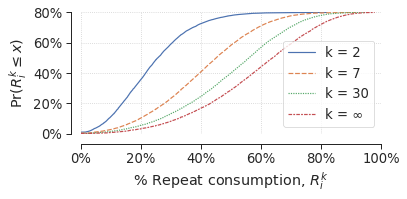

In [7]:
plot_fig3(data)